# Joint embedding of fragmentation spectra and chemical compounds

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import keras
from keras.callbacks import History, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from livelossplot import PlotLossesKeras

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying default
from rdkit.Chem import Draw

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

from functions import *

Using TensorFlow backend.


### Load GNPS+Massbank data

Data contains SMILES of known molecules and also their fragmentation spectra from massbank + gnps.

Collision energies are merged.

In [3]:
import pickle
with open('../data/gnps_massbank_data.p', 'rb') as f:
    data = pickle.load(f)

In [4]:
data['spectra'].shape

(7901, 881)

### Create spectra embedding

Load a simple dense model. This was trained on the training data and is used to map

- From: fragmentation spectra 
- To: 100-dimensional representation

TODO: represent spectra as their LDA topic decomposition

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 881)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               88200     
_________________________________________________________________
dense_2 (Dense)              (None, 881)               88981     
Total params: 177,181
Trainable params: 177,181
Non-trainable params: 0
_________________________________________________________________


/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


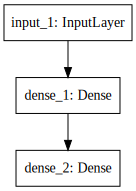

In [5]:
spectra_autoencoder = keras.models.load_model('../models/spectra_autoencoder_gnps_massbank.h5')
spectra_encoder = keras.models.load_model('../models/spectra_encoder_gnps_massbank.h5')
spectra_decoder = keras.models.load_model('../models/spectra_decoder_gnps_massbank.h5')
spectra_autoencoder.summary()
svg = plot_model_in_notebook(spectra_autoencoder)
svg

In [6]:
spectra_latent = spectra_encoder.predict(data['spectra'])
print(spectra_latent.shape)

(7901, 100)


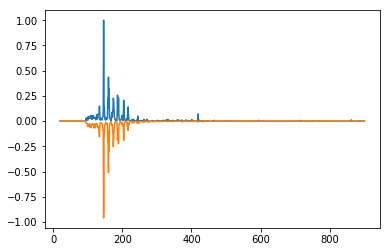

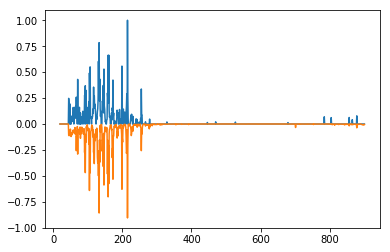

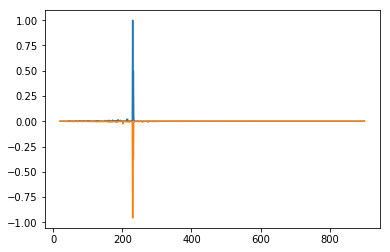

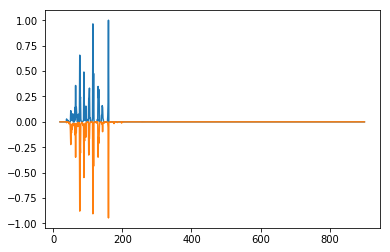

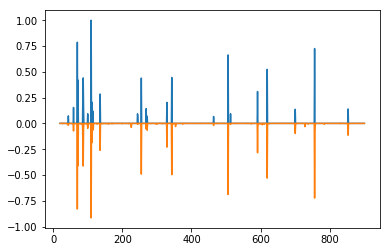

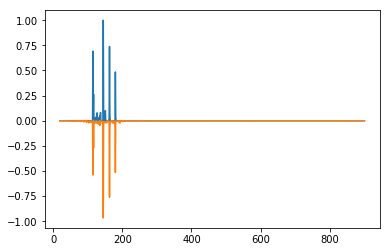

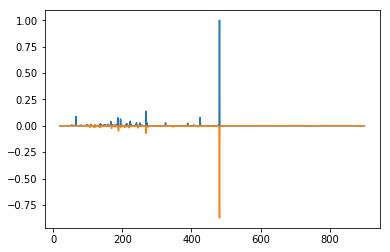

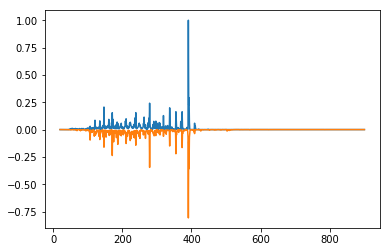

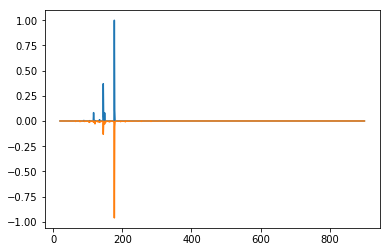

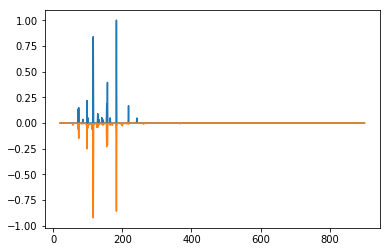

In [9]:
spectra_decoded = spectra_decoder.predict(spectra_latent)
for idx in range(10):
    pos = np.nonzero(data['spectra'][idx])
#     print(data['vocab'][pos])
    plt.plot(data['vocab'], data['spectra'][idx])
    plt.plot(data['vocab'], -spectra_decoded[idx])
    plt.show()

### Create Topological Fingerprints of Molecules

http://www.rdkit.org/docs/GettingStartedInPython.html#fingerprinting-and-molecular-similarity

The fingerprinting algorithm used is similar to that used in the Daylight fingerprinter: it identifies and hashes topological paths (e.g. along bonds) in the molecule and then uses them to set bits in a fingerprint of user-specified lengths. After all paths have been identified, the fingerprint is typically folded down until a particular density of set bits is obtained.

In [10]:
from rdkit.Chem.Fingerprints import FingerprintMols

In [11]:
fingerprints = []
spectra = []
smiles = []
assert len(data['smiles']) == len(data['spectra'])

max_length = 0
for i in range(len(data['smiles'])):
    smile = data['smiles'][i]
    mol = Chem.MolFromSmiles(smile)
    spec = data['spectra'][i]
    try:
        fp = FingerprintMols.FingerprintMol(mol)
        bits = np.array(list(fp.GetOnBits()))
        if max(bits) > max_length:
            max_length = max(bits)
        fingerprints.append(bits)
        spectra.append(data['spectra'][i])
        smiles.append(smile)
    except Exception:
        print('Invalid smile', data['smiles'][i])
        continue
        
fingerprint_arr = np.zeros((len(fingerprints), max_length+1))
for i in range(len(fingerprints)):
    fingerprint = fingerprints[i]
    for bit in fingerprint:
        fingerprint_arr[i][bit] = 1
        
spectra = np.array(spectra)
smiles = np.array(smiles)
spectra_latent = spectra_encoder.predict(spectra)

In [12]:
fingerprint_arr.shape

(7901, 2048)

In [13]:
fingerprint_arr[0]

array([1., 1., 0., ..., 1., 0., 1.])

### Try joint embedding

Objective: build a model that projects spectra and molecules in the same representation space, so that a spectra is close to its molecule in that space, and far away from dissimilar spectra and dissimilar molecules.

Each training point is a triplet of:
- fragmentation spectra, also called an anchor
- compound correctly associated to that spectra, also called the positive example
- compound incorrectly associated to that spectra, also called the negative example

During training, we compute the scores of the anchor to the positive and negative examples (dot products). The optimisation objective is to maximise total positive scores and minimise total negative scores. Then for each training step, we shuffle the negative examples randomly.

See:

- https://pageperso.lis-lab.fr/benoit.favre/dl4nlp/tutorials/05-caption.pdf
- https://arxiv.org/abs/1511.06078

In [14]:
def get_embedding_model(input_dim_spectra, input_dim_molecule, embedding_dim):
    
    spectra_input = Input(shape=(input_dim_spectra,), name='spectra_input')
    smile_input = Input(shape=(input_dim_molecule,), name='positive_molecule')
    noise_input = Input(shape=(input_dim_molecule,), name='negative_molecule')
        
    spectra_pipeline = Dense(embedding_dim, use_bias=False, name='spectra_weights')(spectra_input)
    spectra_pipeline = BatchNormalization(name='bn1')(spectra_pipeline)
    spectra_pipeline = Activation('relu', name='relu1')(spectra_pipeline)
    spectra_pipeline = Dense(embedding_dim, activation='relu', name='spectra_weights2')(spectra_pipeline)

    smile_dense1 = Dense(embedding_dim, use_bias=False, name='molecule_weights') 
    bn = BatchNormalization(name='bn2')
    activation = Activation('relu', name='relu2')
    smile_dense2 = Dense(embedding_dim, activation='relu', name='molecule_weights2')
    smile_pipeline = smile_dense2(activation(bn(smile_dense1(smile_input))))
    noise_pipeline = smile_dense2(activation(bn(smile_dense1(noise_input))))        

    positive_pair = merge([spectra_pipeline, smile_pipeline], mode='dot', name='dot1')
    negative_pair = merge([spectra_pipeline, noise_pipeline], mode='dot', name='dot2')
    concat_output = merge([positive_pair, negative_pair], mode='concat', name='concat')
    embedding_model = Model(input=[spectra_input, smile_input, noise_input], output=concat_output)

    l2_norm = Lambda(lambda  x: K.l2_normalize(x, axis=1))    
    spectra_encoder = Model(input=spectra_input, output=l2_norm(spectra_pipeline))
    smile_encoder = Model(input=smile_input, output=l2_norm(smile_pipeline))
    
    # also see https://github.com/keras-team/keras/issues/150
    def custom_loss(y_true, y_pred):
        positive = y_pred[:,0]
        negative = y_pred[:,1]
        return K.sum(K.maximum(0., 1. - positive + negative))
    
    def accuracy(y_true, y_pred):
        positive = y_pred[:,0]
        negative = y_pred[:,1]
        return K.mean(positive > negative)
    
    embedding_model.compile(loss=custom_loss, optimizer='adam', metrics=[accuracy])
    return embedding_model, spectra_encoder, smile_encoder

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spectra_input (InputLayer)      (None, 100)          0                                            
__________________________________________________________________________________________________
positive_molecule (InputLayer)  (None, 2048)         0                                            
__________________________________________________________________________________________________
negative_molecule (InputLayer)  (None, 2048)         0                                            
__________________________________________________________________________________________________
spectra_weights (Dense)         (None, 100)          10000       spectra_input[0][0]              
__________________________________________________________________________________________________
molecule_w

/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/ipykernel/__main__.py:19: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/ipykernel/__main__.py:20: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/ipykernel/__main__.py:21: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `k

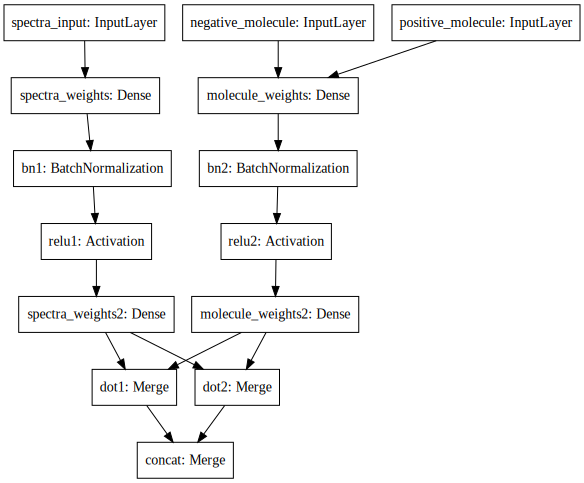

In [15]:
EMBEDDING_DIM = 100
input_dim_spectra = spectra_latent.shape[1]
input_dim_molecule = fingerprint_arr.shape[1]
joint_embedding_model, spectra_encoder, smile_encoder = get_embedding_model(input_dim_spectra, 
                                                                            input_dim_molecule, 
                                                                            EMBEDDING_DIM)
joint_embedding_model.summary()
plot_model_in_notebook(joint_embedding_model)

Preparing training and test data

In [16]:
def shuffle_together(a, b, c, d):
    assert len(a) == len(b)
    assert len(a) == len(c)
    assert len(a) == len(d)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p], d[p]

spectra, spectra_latent, smiles, fingerprint_arr = shuffle_together(spectra, spectra_latent, smiles, fingerprint_arr)
fingerprint_arr = StandardScaler().fit_transform(fingerprint_arr)
spectra_latent = StandardScaler().fit_transform(spectra_latent)

In [17]:
pos = int(len(spectra_latent) * 0.8)
remaining = len(spectra_latent) - pos
print(pos, remaining)

noise = np.copy(fingerprint_arr)
fake_labels = np.zeros((len(spectra_latent), 1))

X_train = [spectra_latent[:pos], fingerprint_arr[:pos], noise[:pos]]
Y_train = fake_labels[:pos]
X_test = [spectra_latent[-remaining:], fingerprint_arr[-remaining:], noise[-remaining:]]
Y_test = fake_labels[-remaining:]

spectra_train = spectra[:pos]
spectra_test = spectra[-remaining:]
smiles_train = smiles[:pos]
smiles_test = smiles[-remaining:]

6320 1581


In [18]:
print(X_train[0].shape, X_train[1].shape, X_train[2].shape)
print(X_test[0].shape, X_test[1].shape, X_test[2].shape)

(6320, 100) (6320, 2048) (6320, 2048)
(1581, 100) (1581, 2048) (1581, 2048)


In [19]:
# rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001,
#                         verbose=1, epsilon=1e-5)
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
# callbacks = [rlr, early_stop]

# tensorboard = keras.callbacks.TensorBoard(log_dir='./graph', histogram_freq=0,  
#           write_graph=True, write_images=True)
# callbacks = [rlr, early_stop, tensorboard]
# if is_notebook():
#     callbacks.append(PlotLossesKeras())

TODO: generate mini-batch properly https://stackoverflow.com/questions/48568062/keras-custom-infinite-data-generator-with-shuffle

In [20]:
# actual training
for epoch in range(1000):
    if epoch % 10 == 0:
        print('\nIteration %d' % epoch)
        verbose=1
    else:
        verbose=0
    np.random.shuffle(noise) # shuffle mismatched smiles
    joint_embedding_model.fit(X_train, Y_train,
        validation_data=[X_test, Y_test], epochs=1,
        batch_size=32, verbose=verbose)


Iteration 0
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 2s 374us/step - loss: 25.9666 - accuracy: 0.6638 - val_loss: 17.9932 - val_accuracy: 0.7571

Iteration 10
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 1s 204us/step - loss: 4.9043 - accuracy: 0.9422 - val_loss: 10.1947 - val_accuracy: 0.8729

Iteration 20
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 1s 222us/step - loss: 3.8682 - accuracy: 0.9551 - val_loss: 10.5948 - val_accuracy: 0.8729

Iteration 30
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 1s 200us/step - loss: 2.6647 - accuracy: 0.9668 - val_loss: 9.1898 - val_accuracy: 0.8988

Iteration 40
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 1s 234us/step - loss: 2.5792 - accuracy: 0.9696 - va

6320/6320 [==============================] - 1s 213us/step - loss: 0.1848 - accuracy: 0.9978 - val_loss: 10.3075 - val_accuracy: 0.9133

Iteration 790
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 1s 225us/step - loss: 0.4427 - accuracy: 0.9945 - val_loss: 10.9725 - val_accuracy: 0.9178

Iteration 800
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 2s 257us/step - loss: 0.2303 - accuracy: 0.9970 - val_loss: 11.3092 - val_accuracy: 0.9165

Iteration 810
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 1s 211us/step - loss: 0.3958 - accuracy: 0.9951 - val_loss: 10.1675 - val_accuracy: 0.9203

Iteration 820
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 1s 206us/step - loss: 0.5060 - accuracy: 0.9953 - val_loss: 9.8633 - val_accuracy: 0.9209

Iteration 830
Train on 6320 

In [21]:
# joint_embedding_model.save('../models/joint_embedding_gnps_massbank.h5')
# spectra_encoder.save('../models/joint_spectra_encoder_gnps_massbank.h5')
# smile_encoder.save('../models/joint_smile_encoder_gnps_massbank.h5')

### Visualise the joint embedding results

In [32]:
def visualise_embedding(spectra_data, molecule_data, spectra_encoder, smile_encoder):
    
    embedded_spectra = spectra_encoder.predict(spectra_data)
    embedded_molecules = smile_encoder.predict(molecule_data)
    embedded_combined = np.concatenate([embedded_spectra, embedded_molecules], axis=0)
    
    PCA_COMPONENTS = 50
    pca = PCA(n_components = PCA_COMPONENTS)
    latent_proj = pca.fit_transform(embedded_combined)
    covariance = pca.get_covariance()
    evr = pca.explained_variance_ratio_
    print('Explained variations -- first two PCs: %.2f' % (evr[0] + evr[1]))
    print('Explained variations -- all components: %.2f' % np.sum(evr))
    print(evr)
        
    plt.figure(figsize=(8, 8))
    plt.scatter(latent_proj[0:len(embedded_spectra), 0], latent_proj[0:len(embedded_spectra), 1], marker='x', c='red', s=1)
    plt.scatter(latent_proj[len(embedded_spectra)+1:, 0], latent_proj[len(embedded_spectra)+1:, 1], marker='.', c='blue', s=1)
    plt.title('Joint embedding of fragmentation spectra (red) and molecules (blue)')

Visualise embedding on training data

Explained variations -- first two PCs: 0.17
Explained variations -- all components: 0.86
[0.10029154 0.06922178 0.04631508 0.03481941 0.03314773 0.03146083
 0.02764542 0.02526957 0.02457258 0.02323464 0.02202139 0.02077834
 0.02019027 0.01868906 0.01699609 0.01691164 0.01637797 0.01583146
 0.01544158 0.01493965 0.01424247 0.01350488 0.01326183 0.01263413
 0.01221608 0.01166829 0.01149521 0.01103237 0.01044252 0.0099869
 0.00993355 0.00936417 0.00919496 0.009122   0.00888131 0.0081688
 0.00794959 0.00771175 0.00736608 0.00728647 0.0071169  0.00699977
 0.00652154 0.00609762 0.00598383 0.00586251 0.00568763 0.0054968
 0.00542191 0.00532145]


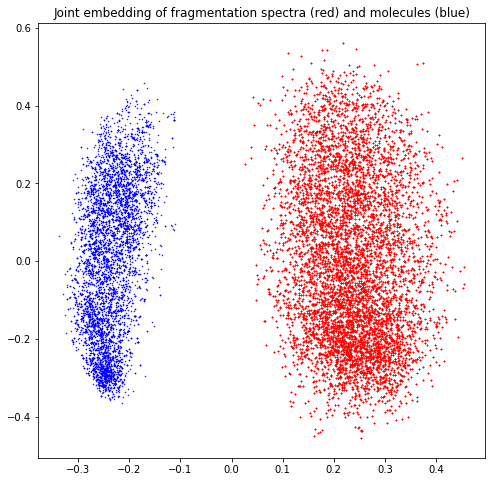

In [33]:
visualise_embedding(X_train[0], X_train[1], spectra_encoder, smile_encoder)

Visualise embedding on testing data

Explained variations -- first two PCs: 0.17
Explained variations -- all components: 0.87
[0.1002564  0.07061858 0.04542507 0.03782153 0.03547406 0.03229032
 0.02950074 0.02580541 0.02483574 0.02355369 0.02275342 0.02121533
 0.02020299 0.01814059 0.01778915 0.0173762  0.01637362 0.01595413
 0.01514917 0.01456048 0.01419916 0.01350752 0.01296561 0.01269786
 0.01216256 0.01158795 0.01119006 0.0109483  0.01048691 0.01014099
 0.00985149 0.00970819 0.00908558 0.00858592 0.00842475 0.00826395
 0.0079249  0.00783814 0.00734509 0.00712118 0.00694978 0.00664287
 0.00652243 0.0061152  0.00594786 0.00573419 0.00553101 0.00542291
 0.00523342 0.00495055]


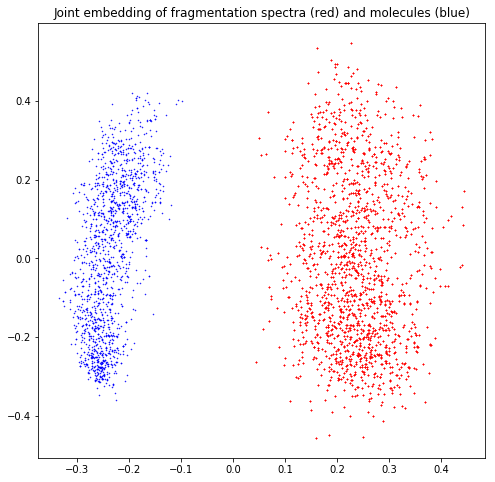

In [34]:
visualise_embedding(X_test[0], X_test[1], spectra_encoder, smile_encoder)

### Evaluation

In [35]:
embedded_spectra = spectra_encoder.predict(X_test[0])
embedded_molecules = smile_encoder.predict(X_test[1])

In [36]:
x = embedded_spectra[0]
print(x)
print(np.dot(x, x))

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.29126057 0.         0.         0.         0.
 0.         0.         0.08974387 0.         0.         0.
 0.         0.         0.19179429 0.         0.3013211  0.
 0.         0.41358823 0.17388801 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.29996306 0.         0.
 0.         0.0089972  0.         0.         0.         0.
 0.         0.         0.05971599 0.         0.         0.
 0.         0.2689581  0.         0.00793786 0.         0.37982413
 0.         0.         0.         0.         0.         0.
 0.         0.         0.04413252 0.         0.         0.
 0.         0.         0.32121038 0.         0.         0.05622235
 0.         0.         0.3798751  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.12393191 0.    

In [37]:
plt.rcParams['figure.figsize'] = (8,8)

(1581, 1581)


Text(0.5,1.05,'Dot product')

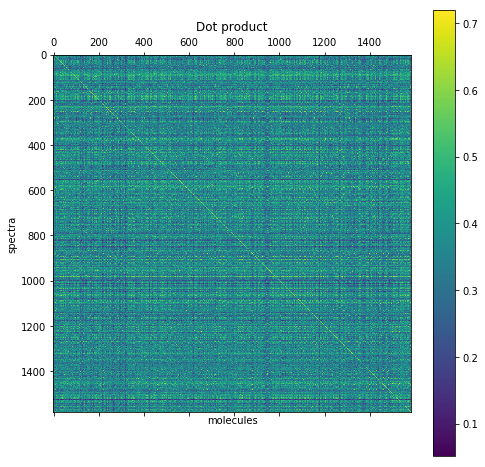

In [38]:
scores = np.dot(embedded_spectra, embedded_molecules.T)
print(scores.shape)
plt.matshow(scores)
plt.colorbar()
plt.xlabel('molecules')
plt.ylabel('spectra')
plt.title('Dot product')

In [74]:
def precision_at(n, scores):
    found = 0.0
    total = len(scores)
    results = {}
    for i in range(total):
        row = scores[i]
        max_idx = row.argsort()[-n:][::-1]
        if i in max_idx:
            found += 1
            correct = True
        else:
            correct = False
        retrieved = list(zip(max_idx, row[max_idx]))
        print(i, correct, retrieved)
        results[i] = retrieved
    precision = found/total
    return precision, found, total, results

In [75]:
prec, found, total, results = precision_at(5, scores)

0 False [(1166, 0.56537837), (294, 0.56537837), (1429, 0.5591967), (598, 0.55338633), (1067, 0.5412385)]
1 False [(155, 0.544204), (301, 0.53737974), (579, 0.5358155), (983, 0.5267784), (792, 0.52446765)]
2 True [(2, 0.6724998), (181, 0.6724998), (1548, 0.6724998), (446, 0.6724998), (875, 0.600847)]
3 False [(451, 0.5020422), (185, 0.50107545), (574, 0.49870506), (414, 0.4971486), (718, 0.49714756)]
4 False [(942, 0.51257104), (627, 0.50924194), (1046, 0.49063665), (1552, 0.4888267), (224, 0.48209557)]
5 False [(1043, 0.5555625), (1530, 0.5532455), (497, 0.5532455), (998, 0.5532455), (824, 0.5532455)]
6 True [(535, 0.6348786), (283, 0.6301417), (6, 0.62054646), (375, 0.6198921), (284, 0.6177208)]
7 False [(753, 0.6171507), (1067, 0.59628236), (997, 0.59452295), (137, 0.59240866), (515, 0.59240866)]
8 False [(699, 0.5725217), (151, 0.5653927), (1460, 0.5653927), (1190, 0.5618497), (494, 0.54673004)]
9 False [(240, 0.5917216), (784, 0.59172153), (591, 0.59008116), (934, 0.59008116), (108

455 False [(1134, 0.6052618), (114, 0.6052618), (366, 0.5882791), (328, 0.58419496), (1427, 0.58419496)]
456 False [(230, 0.6006456), (161, 0.5768068), (823, 0.5726783), (1088, 0.56903696), (867, 0.56903696)]
457 False [(385, 0.57563657), (256, 0.5634361), (1571, 0.55983204), (35, 0.55983204), (967, 0.5535441)]
458 False [(105, 0.5414556), (426, 0.5414556), (667, 0.5283681), (1201, 0.52366203), (906, 0.5177062)]
459 False [(1268, 0.5546025), (1091, 0.54719245), (717, 0.54434097), (1577, 0.5443409), (394, 0.54122937)]
460 False [(147, 0.47584122), (879, 0.46231446), (602, 0.45523137), (788, 0.4533081), (91, 0.44821694)]
461 False [(881, 0.59402806), (682, 0.59355134), (1397, 0.58894104), (1459, 0.5883275), (1003, 0.58595127)]
462 True [(462, 0.5320442), (322, 0.5300992), (1580, 0.51785564), (716, 0.5000648), (1059, 0.5000648)]
463 True [(758, 0.59391284), (529, 0.5644334), (167, 0.5644334), (1193, 0.5590135), (463, 0.5528617)]
464 True [(1211, 0.5766244), (1167, 0.5672947), (467, 0.5670

661 True [(661, 0.5274832), (1102, 0.50056607), (475, 0.50056607), (262, 0.49273223), (341, 0.49160025)]
662 False [(1420, 0.625104), (836, 0.625104), (1188, 0.625104), (1550, 0.5919563), (1458, 0.5869914)]
663 True [(1535, 0.5899947), (663, 0.58721524), (1251, 0.58721524), (1220, 0.58372843), (1315, 0.58372843)]
664 True [(472, 0.6081473), (1045, 0.6023732), (664, 0.5982935), (1564, 0.5851777), (1271, 0.57911485)]
665 True [(357, 0.5948527), (665, 0.59135264), (543, 0.59135264), (766, 0.58822733), (618, 0.5835724)]
666 False [(353, 0.5801384), (327, 0.562002), (972, 0.559602), (440, 0.55950373), (506, 0.55658114)]
667 True [(238, 0.5479732), (1265, 0.5479732), (216, 0.54600525), (218, 0.5412107), (667, 0.5344329)]
668 False [(1272, 0.61860067), (1501, 0.5886262), (263, 0.582191), (95, 0.5753187), (659, 0.573779)]
669 False [(1124, 0.6021764), (1454, 0.595688), (959, 0.5899456), (811, 0.58053195), (442, 0.5767729)]
670 False [(1201, 0.57920206), (1052, 0.56304115), (637, 0.5560817), (2

980 True [(918, 0.5699028), (980, 0.5646446), (1462, 0.5183642), (353, 0.46621597), (1456, 0.46213764)]
981 True [(256, 0.5666667), (385, 0.5458117), (1212, 0.5381032), (313, 0.5333745), (981, 0.532015)]
982 False [(930, 0.6994442), (1278, 0.69257236), (588, 0.6907131), (703, 0.6852929), (437, 0.6786579)]
983 True [(155, 0.54574496), (579, 0.5309629), (983, 0.52767044), (792, 0.5237225), (186, 0.5184042)]
984 True [(569, 0.5292681), (984, 0.5292681), (322, 0.5184589), (201, 0.5071406), (57, 0.49840662)]
985 True [(1306, 0.60288864), (985, 0.5950971), (1162, 0.58831006), (405, 0.5858923), (1140, 0.5839831)]
986 False [(1163, 0.6089352), (253, 0.604459), (784, 0.6044557), (240, 0.6044556), (832, 0.5968914)]
987 False [(240, 0.4788057), (784, 0.4788057), (739, 0.46602133), (1115, 0.45923328), (205, 0.45261955)]
988 True [(988, 0.5162345), (734, 0.516067), (735, 0.49905294), (583, 0.4918954), (643, 0.4918954)]
989 False [(851, 0.5944539), (1536, 0.5648779), (865, 0.55373526), (355, 0.55104

1299 False [(948, 0.5975607), (766, 0.593075), (357, 0.5902785), (371, 0.5838461), (508, 0.5816164)]
1300 True [(303, 0.65434915), (566, 0.65434915), (568, 0.6205901), (767, 0.6081651), (1300, 0.60521924)]
1301 False [(1429, 0.5995065), (652, 0.59500223), (1067, 0.5932661), (294, 0.59166044), (1166, 0.59166044)]
1302 False [(1017, 0.5800557), (212, 0.57857114), (981, 0.5783056), (757, 0.5783056), (1447, 0.5638566)]
1303 True [(714, 0.6420675), (793, 0.6420675), (1303, 0.6376859), (967, 0.6343353), (1312, 0.63429105)]
1304 True [(1304, 0.57778734), (857, 0.57382804), (1462, 0.5736903), (918, 0.5699584), (1025, 0.56773275)]
1305 False [(1076, 0.6032302), (406, 0.5908218), (251, 0.5842571), (1563, 0.56853926), (322, 0.56708676)]
1306 False [(1162, 0.62113255), (997, 0.6172325), (515, 0.61135507), (137, 0.61135507), (871, 0.6069333)]
1307 True [(201, 0.60743016), (1307, 0.548272), (954, 0.53784734), (1382, 0.5347277), (768, 0.532459)]
1308 True [(1308, 0.54793143), (473, 0.5045802), (1257,

In [63]:
print('Found %d/%d (%.2f)' % (found, total, prec))

Found 671/1581 (0.42)


In [64]:
def plot_spectra_and_molecule(idx, spectra, smiles):    
    pos = np.nonzero(spectra[idx])
    plt.plot(data['vocab'], spectra[idx])
    plt.show()
    smile = smiles[idx]    
    print(smile)
    mol = Chem.MolFromSmiles(smile)
    mol_drawing = Draw.MolToMPL(mol, size=(150, 150))
    plt.show()

In [82]:
def plot_results(idx, spectra_test, smiles_test, results):
    plt.rcParams['figure.figsize'] = (4,4)
    
    print('Query')
    plot_spectra_and_molecule(idx, spectra_test, smiles_test)
    
    print("Retrieved")
    retrieved = results[idx]
    for j, score in retrieved:
        print('Molecule %d score %.2f' % (j, score))
        plot_spectra_and_molecule(j, spectra_test, smiles_test)

Query


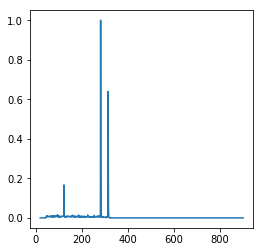

O=C(C1=CC=C(F)C=C1)C=2C=CC=3N=C(N=C(O)OC)NC3C2


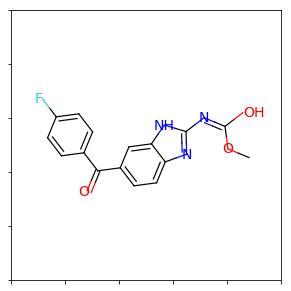

Retrieved
Molecule 1574 score 0.54


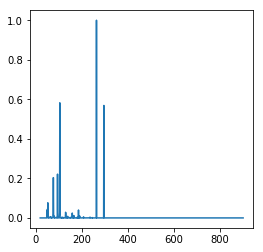

O=C(C1=CC=CC=C1)C=2C=CC=3N=C(N=C(O)OC)NC3C2


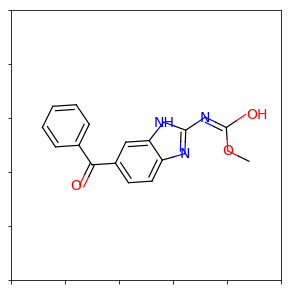

Molecule 19 score 0.53


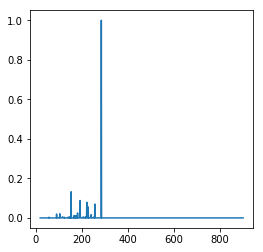

O=C1N(C=2C=CC(Cl)=CC2C(=NC1)C3=CC=CC=C3)C


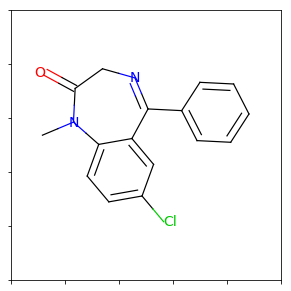

Molecule 96 score 0.53


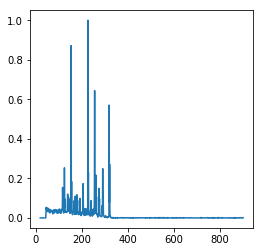

O=C1N(C=2C=CC(Cl)=CC2C(=NC1)C3=CC=C(Cl)C=C3)C


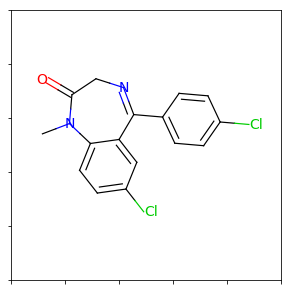

Molecule 12 score 0.52


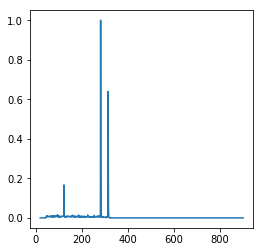

O=C(C1=CC=C(F)C=C1)C=2C=CC=3N=C(N=C(O)OC)NC3C2


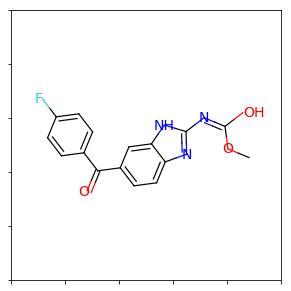

Molecule 1418 score 0.51


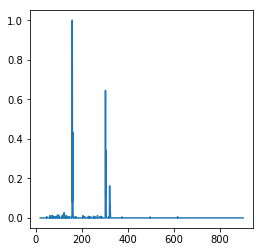

O=C(O)C1=NN(C2=CC=CC=C12)CC=3C=CC(Cl)=CC3Cl


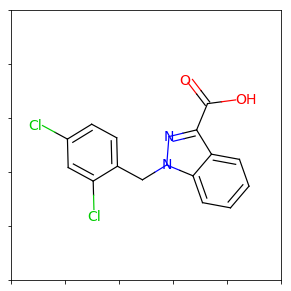

In [86]:
plot_results(12, spectra_test, smiles_test, results)